# Expansion of weight matrices

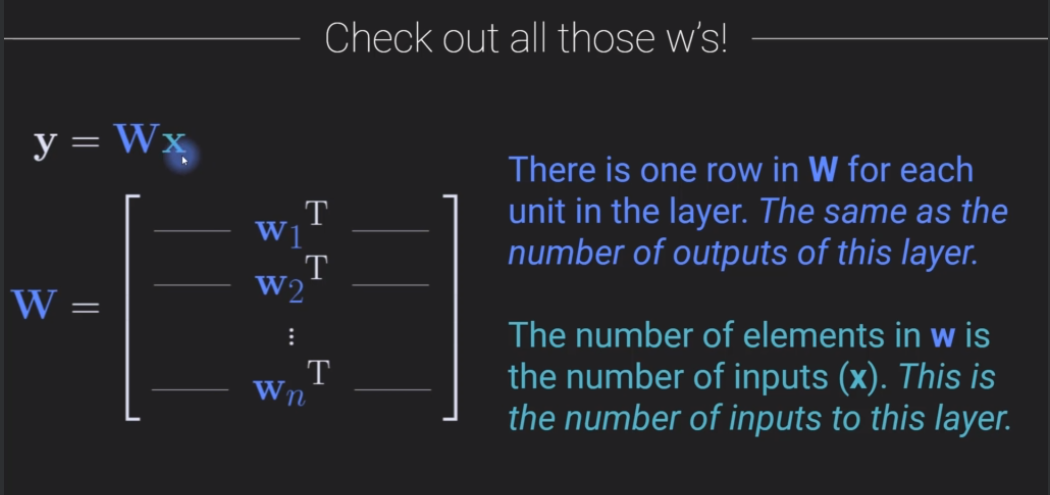

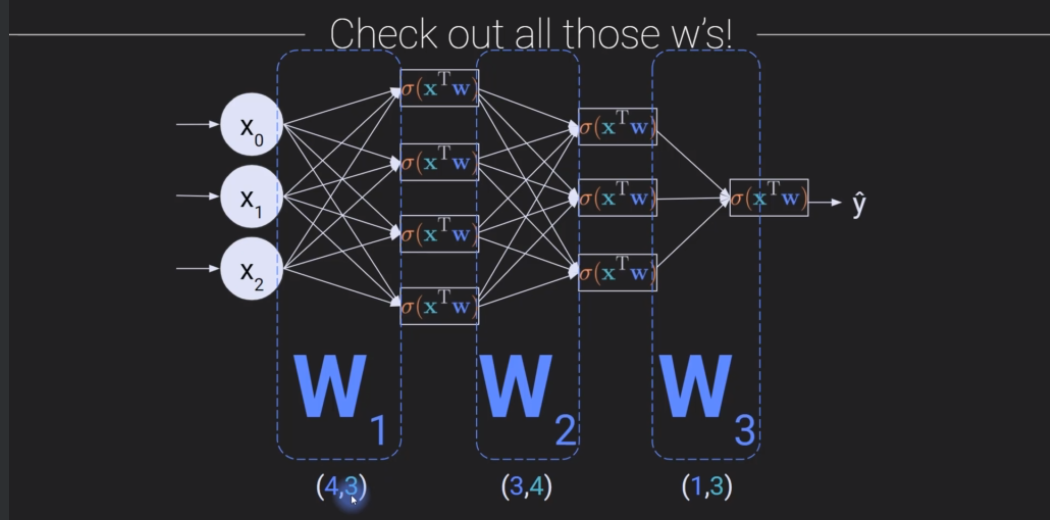

### Organization of W = (outputs, inputs) or (current, previous)

In [1]:
import torch
import torch.nn as nn

In [2]:
mdl = nn.Sequential(
    nn.Linear(10, 14),
    nn.Linear(14, 19),
    nn.Linear(19, 8)
)

mdl

Sequential(
  (0): Linear(in_features=10, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=19, bias=True)
  (2): Linear(in_features=19, out_features=8, bias=True)
)

In [3]:
# printing size of weight matrices in each layer
for i in range(len(mdl)):
    print(mdl[i].weight.shape)

torch.Size([14, 10])
torch.Size([19, 14])
torch.Size([8, 19])


# Demo of weight initializations

Models cannot learn when ALL trainable parameters are initialized tp same value

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

### Splitting the data into train and test, and loading

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [5]:
def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.01)
    
    return net, lossfn, optim

### Exploring the weights

In [6]:
tempNet = createMNISTNet()[0]
print(tempNet)

MNISTNet(
  (ip): Linear(in_features=784, out_features=64, bias=True)
  (h1): Linear(in_features=64, out_features=32, bias=True)
  (h2): Linear(in_features=32, out_features=32, bias=True)
  (op): Linear(in_features=32, out_features=10, bias=True)
)


In [11]:
print('Weights for layer h1:')
print(tempNet.h1.weight.data)

Weights for layer h1:
tensor([[-0.0171, -0.0406,  0.0099,  ...,  0.1168, -0.0543, -0.1064],
        [ 0.0447,  0.0106, -0.0662,  ...,  0.0955,  0.0330,  0.0066],
        [-0.0295,  0.0119, -0.0637,  ...,  0.0263,  0.0654,  0.1005],
        ...,
        [ 0.0845, -0.1143,  0.0033,  ...,  0.0541,  0.0225,  0.1112],
        [-0.1192, -0.1204,  0.1012,  ..., -0.0909,  0.1162, -0.1098],
        [ 0.1043, -0.1213, -0.0062,  ...,  0.0649,  0.0911, -0.0512]])


In [12]:
# function to train the model

def trainModel(net, lossfn, optim):
    
    nEp = 10
#     net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # train loop
    for i in range(nEp):
                
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        X, y = next(iter(testLoader))
        yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
    # end of training loop
    
    return net, trainAcc, testAcc, losses

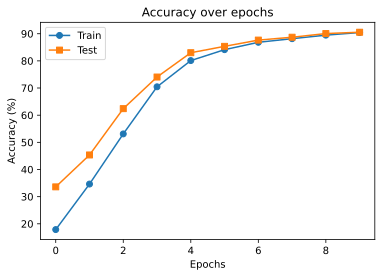

In [15]:
# Run the model without changing the weights; this will be the baseline performance.
# Notice the model creation is outside the function2train
net_base, lossfn, optim = createMNISTNet()
net_base, trainAcc_base, testAcc_base, losses = trainModel(net_base, lossfn, optim)
# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

### Setting all weights of layer 1 to 0

In [21]:
# fresh instance
net_zero, lossfn, optim = createMNISTNet()

# initialize first layer to zero
net_zero.h1.weight.data = torch.zeros_like(net_zero.h1.weight)

net_zero.h1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

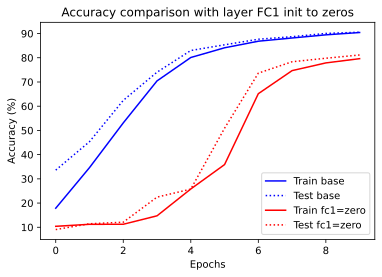

In [22]:
# running the model

net_zero, trainAcc_zero, testAcc_zero, losses = trainModel(net_zero, lossfn, optim)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'r-', range(len(testAcc_zero)),testAcc_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [23]:
print(net_zero.h1.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0433,  0.0046, -0.0622,  ..., -0.0303, -0.0364, -0.0406],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0574,  0.0345, -0.1035,  ...,  0.1689, -0.0290,  0.0674],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


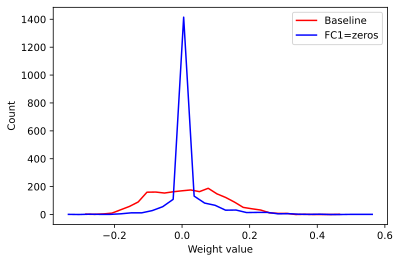

In [25]:
# show the distributions in a histogram
y,x = np.histogram(net_base.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_zero.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

### Repeating the experiment with all learnable parameters set to 0

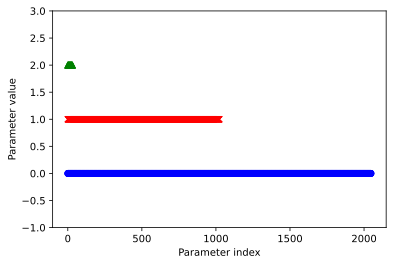

In [28]:
# Change the weights before training
net_allzero,lossfun,optimizer = createMNISTNet()

# loop over parameters and set them all to zeros
for p in net_allzero.named_parameters():
    p[1].data = torch.zeros_like( p[1].data )


# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+net_allzero.h1.weight.data.flatten(),'bo') 
plt.plot(1+net_allzero.h2.weight.data.flatten(),'rx')
plt.plot(2+net_allzero.h1.bias.data.flatten(),'g^')
plt.xlabel('Parameter index')
plt.ylim([-1,3])
plt.ylabel('Parameter value')
plt.show()

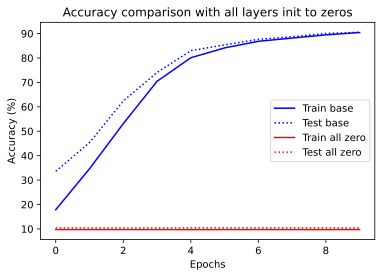

In [29]:
# run the model and show the results
net_allzero, trainAcc_allzero, testAcc_allzero, losses = trainModel(net_allzero, lossfn, optim)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

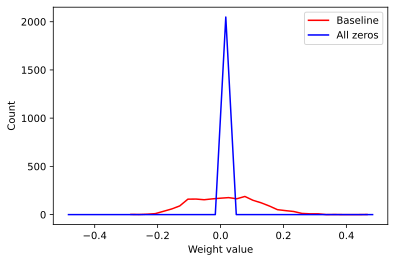

In [30]:
# show the distributions in a histogram
y,x = np.histogram(net_base.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_allzero.h1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

### Initializing all to 1s?

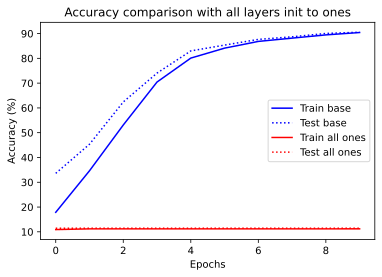

In [32]:
# Change the weights before training
net_allone,lossfun,optimizer = createMNISTNet()

# loop over parameters and set them all to zeros
for p in net_allone.named_parameters():
    p[1].data = torch.zeros_like( p[1].data ) + 1


# run the model and show the results
net_allone, trainAcc_allone,testAcc_allone,losses = trainModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Observations

Random weights allow for variability in direction for descent.  
__Stochastic Facilitation__ - model simply cannot learn unless it has a bit of noise.  
If all of the weights are of same values, there is no way to know which weights to adjust in which direction - __no diversity__.  
With random weights, adjustment is possible and easier.  
__Weight symmetry__ - all weights are equal (or) of same value. Randomizing weights is called __breaking symmetry__.

### How to initialize weights?

Two distributions are used - Gaussian and Uniform (flat). Standard deviation should be relatively small. 

Small weights (close to zero) risk vanishing graidents. Large weights risk exploding gradients.

__Solution__ - set the variance of weights proportional to size of network.

# Xavier and Kaming Initializations

__Kaiming__ - weights initialized from uniform distribution within boundaries that are symmetric to 0, and are defined according to number of inputs __into__ the layer.

__Xavier__ - weights drawn randomly in normal distribution (symmetric) with mean 0. Variance is set by total size of weight matrix.

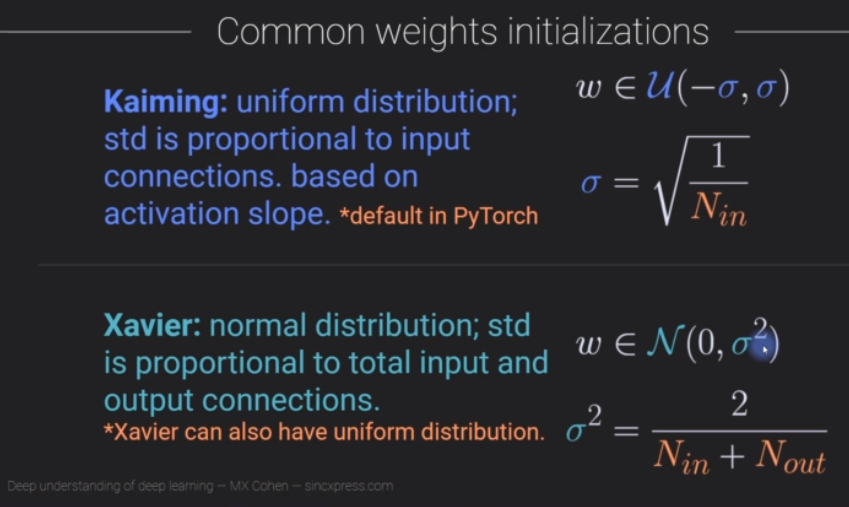

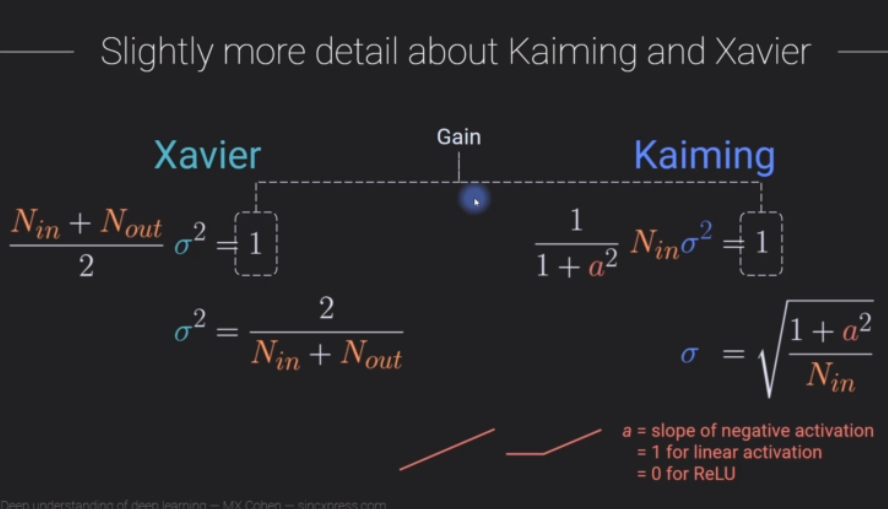

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

In [39]:
class theNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.ip = nn.Linear(2, 128)
        self.h1 = nn.Linear(128, 128)
        self.h2 = nn.Linear(128, 64)
        self.h3 = nn.Linear(64, 16)
        self.op = nn.Linear(16, 2)
    
    def forward(self, x):
        x = F.relu(self.ip(x))
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = F.relu(self.h3(x))
        return self.op(x)

In [23]:
net = theNet()
print(net)

theNet(
  (ip): Linear(in_features=2, out_features=8, bias=True)
  (h1): Linear(in_features=8, out_features=128, bias=True)
  (h2): Linear(in_features=128, out_features=64, bias=True)
  (h3): Linear(in_features=64, out_features=16, bias=True)
  (op): Linear(in_features=16, out_features=2, bias=True)
)


There are 338 bias parameters.
There are 25888 weight parameters.


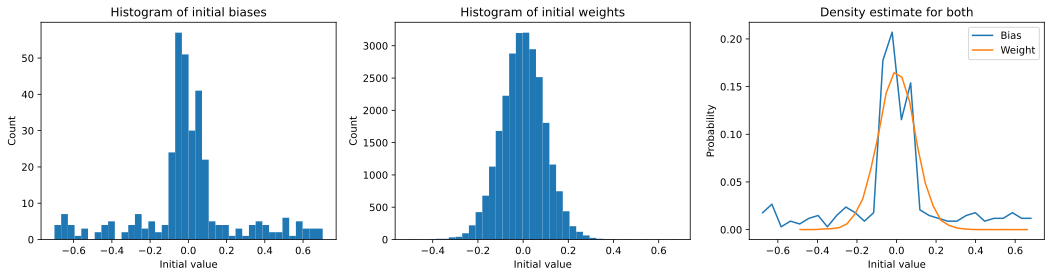

In [41]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
    if 'bias' in p[0]:
        allbiases = np.concatenate( (allbiases,p[1].data.numpy().flatten()),axis=0 )
    elif 'weight' in p[0]:
        allweight = np.concatenate( (allweight,p[1].data.numpy().flatten()),axis=0 )


# how many are there?
print(f'There are {len(allbiases)} bias parameters.')
print(f'There are {len(allweight)} weight parameters.')


# show their histograms
fig,ax = plt.subplots(1,3,figsize=(18,4))

ax[0].hist(allbiases,40)
ax[0].set_title('Histogram of initial biases')


ax[1].hist(allweight,40)
ax[1].set_title('Histogram of initial weights')



# collect histogram data to show as line plots
yB,xB = np.histogram(allbiases,30)
yW,xW = np.histogram(allweight,30)

ax[2].plot((xB[1:]+xB[:-1])/2,yB/np.sum(yB),label='Bias')
ax[2].plot((xW[1:]+xW[:-1])/2,yW/np.sum(yW),label='Weight')
ax[2].set_title('Density estimate for both')
ax[2].legend()


# plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel('Initial value')
    ax[i].set_ylabel('Count')

ax[2].set_ylabel('Probability')

plt.show()

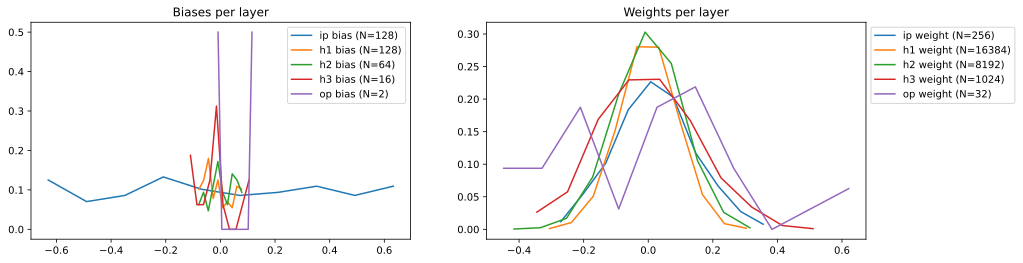

In [42]:
# layer specific distribution


fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():

  # get the data and compute their histogram
    thesedata = p[1].data.numpy().flatten()
    y,x = np.histogram(thesedata,10)

    # for the bias
    if 'bias' in p[0]:
        ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

    # for the weights
    elif 'weight' in p[0]:
        ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))



ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [34]:
# output bias distribution
print(net.op.bias.data)

tensor([-0.2024, -0.1861])


In [43]:
# test whether numbers from our prediction match the formula

bias_range = [torch.min(net.h1.bias.data).item(), torch.max(net.h1.bias.data).item()]
bias_cnt = len(net.h1.bias.data)

sigma = np.sqrt(1/bias_cnt)

print('Theoretical sigma =', sigma)
print('Empirical range =', bias_range)

Theoretical sigma = 0.08838834764831845
Empirical range = [-0.08705747872591019, 0.08654145151376724]


### Initializing with Xavier method

In [40]:
net = theNet()

# changing the weights and leaving the biases as Kaiming (default)
for i in net.named_parameters():
    if 'weight' in i[0]:
        nn.init.xavier_normal_(i[1].data) # python methods with _ ending operate in-place

In [45]:
# theoretical vs empirical

weight_var = torch.var(net.ip.weight.data.flatten()).item()
weight_cnt = len(net.ip.weight.data)

sigma2 = 2 / (weight_cnt + weight_cnt) 
print('Theoretical sigma =', sigma2)
print('Empirical variance =', weight_var)

Theoretical sigma = 0.0078125
Empirical variance = 0.015340614132583141


# Freezing weights 

__Freezing__ - switching off gradient descent in that layer. Weights will not change, hence the layer will no longer learn.

Used when working with pre-trained/downloaded networks. Network is already trained and we "fine-tune" it to specific dataset. Also known as __transfer learning__.

In [46]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

### Splitting the data into train and test, and loading

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [48]:
def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return torch.log_softmax(self.op(x), axis=1)
            # using log_softmax explicitly as NLLLoss is used 
            # instead of CELoss that implicitly computes softmax
            
    net = MNISTNet()
    
    lossfn = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.001) # SGD to slow down the learning
    
    return net, lossfn, optim

### Looking at requires_grad function

In [68]:
N = createMNISTNet()[0]

In [55]:
print(N.h1) # inspecting layer
print(N.h1.weight) # looking at weight
print(N.h1.weight.requires_grad)
print(N.h1.weight.detach()) # gives only tensor part

Linear(in_features=64, out_features=32, bias=True)
Parameter containing:
tensor([[ 0.0668,  0.0773, -0.1021,  ..., -0.0209, -0.0020,  0.0184],
        [-0.0700, -0.0307,  0.0742,  ...,  0.0062, -0.0666, -0.1057],
        [-0.0856,  0.1151,  0.1047,  ..., -0.0803,  0.0034, -0.0681],
        ...,
        [-0.0967,  0.1095,  0.1115,  ..., -0.1238, -0.0834, -0.0804],
        [ 0.1110, -0.0221, -0.1036,  ..., -0.1053,  0.0095, -0.0346],
        [-0.0627,  0.0899,  0.1201,  ..., -0.1121,  0.1232, -0.0333]],
       requires_grad=True)
True
tensor([[ 0.0668,  0.0773, -0.1021,  ..., -0.0209, -0.0020,  0.0184],
        [-0.0700, -0.0307,  0.0742,  ...,  0.0062, -0.0666, -0.1057],
        [-0.0856,  0.1151,  0.1047,  ..., -0.0803,  0.0034, -0.0681],
        ...,
        [-0.0967,  0.1095,  0.1115,  ..., -0.1238, -0.0834, -0.0804],
        [ 0.1110, -0.0221, -0.1036,  ..., -0.1053,  0.0095, -0.0346],
        [-0.0627,  0.0899,  0.1201,  ..., -0.1121,  0.1232, -0.0333]])


In [69]:
# switching off all layers except input

for i in N.named_parameters():
    if 'ip' not in i[0]:
        i[1].requires_grad = False

for p in N.named_parameters():
    print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer ip.weight: True
Requires_grad status in layer ip.bias: True
Requires_grad status in layer h1.weight: False
Requires_grad status in layer h1.bias: False
Requires_grad status in layer h2.weight: False
Requires_grad status in layer h2.bias: False
Requires_grad status in layer op.weight: False
Requires_grad status in layer op.bias: False


In above network, backpropogation will now change weights only in input layers, not in any other layer

In [76]:
# function to train the model

def trainModel(net, lossfn, optim):
    
    nEp = 100
#     net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # train loop
    for i in range(nEp):
        
        '''
        for first half of training, switch off learning in all layers
        exccept output
        '''
        if i < (nEp/2):
            for p in net.named_parameters():
                if 'op' not in p[0]:
                    p[1].requires_grad = False
        else:
            for p in net.named_parameters():
                p[1].requires_grad = True
                
        
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        X, y = next(iter(testLoader))
        with torch.no_grad(): # sets requires_grad to false for all layers
            yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
    # end of training loop
    
    return net, trainAcc, testAcc, losses

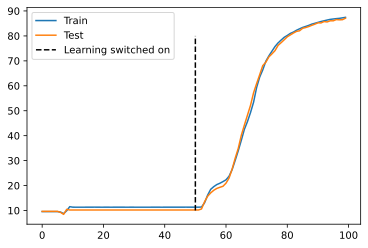

In [77]:
# create the network
net, lossfn, optim = createMNISTNet()

# train the model
net, trainAcc, testAcc, losses = trainModel(net, lossfn, optim)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.legend()
plt.show()

# Learning-related changes in weights

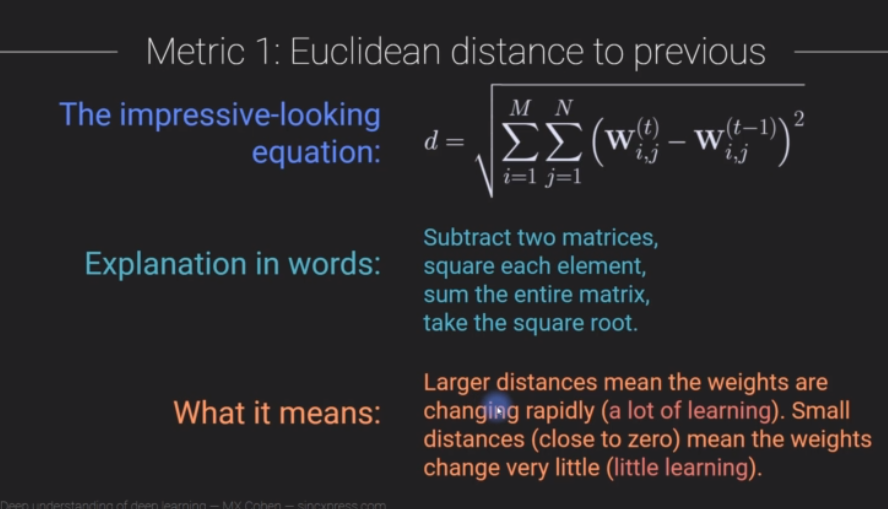

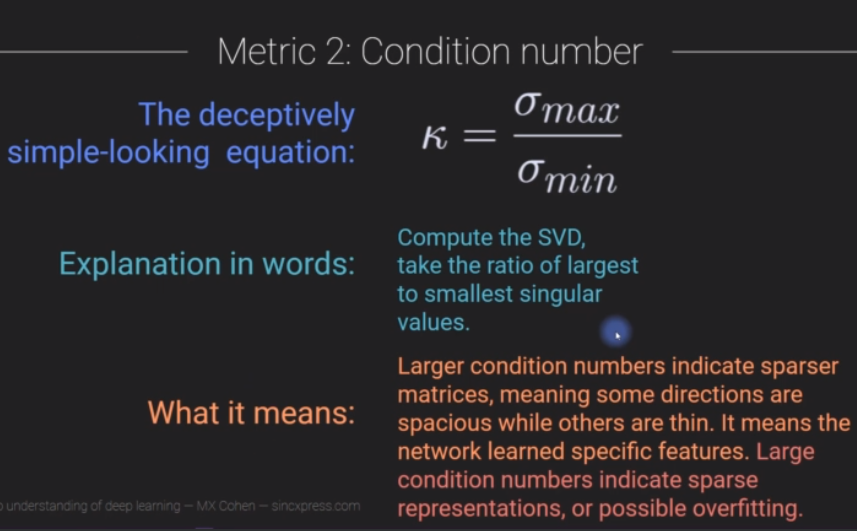


Every matrix has a geometric representation (in terms of shape) 

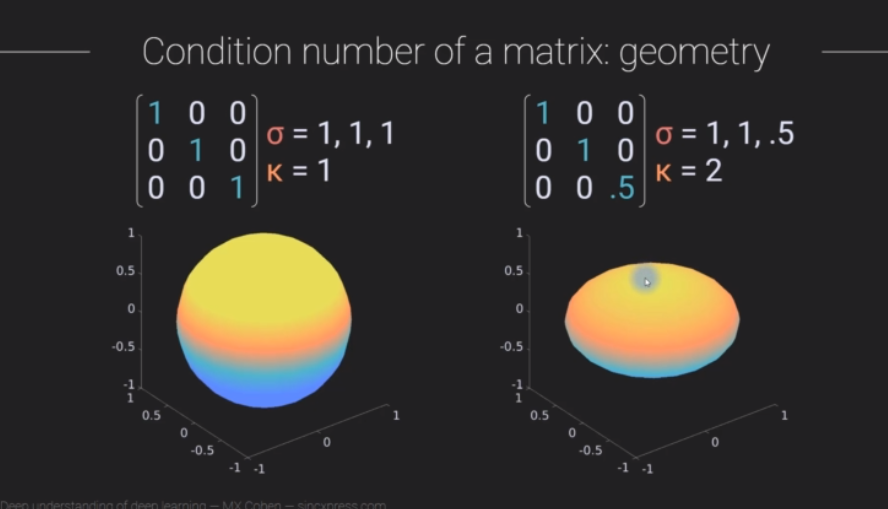

As the condition number increases, some dimensions in geometry are flattened or squeezed and other dimensions are stretched out.

K is computed seperately for each layer. If layer is learning specific representations or features in data space, then some directions in weight matrix will be extended while others will shrink. Large K -> sparse matrices -> possible overfitting

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

from IPython import display
display.set_matplotlib_formats('svg')

data = np.loadtxt(open('../data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:, 0]
data = data[:, 1:]

# normalizing data to a range of 0-1

dataNorm = data/np.max(data)

### Splitting the data into train and test, and loading

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()  # long = int64

X_train, X_test, y_train, y_test = train_test_split(dataT, labelsT, test_size=.1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

batchsize = 32
trainLoader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, drop_last=True)
testLoader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

def createMNISTNet():
    
    class MNISTNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ip = nn.Linear(784, 64)
            self.h1 = nn.Linear(64, 32)
            self.h2 = nn.Linear(32, 32)
            self.op = nn.Linear(32, 10)
        
        def forward(self, x):
            x = F.relu(self.ip(x))
            x = F.relu(self.h1(x))
            x = F.relu(self.h2(x))
            return self.op(x)

            
    net = MNISTNet()
    
    lossfn = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(net.parameters(), lr=.001) # SGD to slow down the learning
    
    return net, lossfn, optim

In [127]:
# function to train the model

def trainModel():
    
    nEp = 60
    net, lossfn, optim = createMNISTNet()
    losses, trainAcc, testAcc = torch.zeros(nEp), [], []
    
    # initializing weight change matrices
    weight_change = np.zeros((nEp, 4)) # 4 -> number of layers in network
    weight_cond = np.zeros((nEp, 4))
    
    # train loop
    for i in range(nEp):
        
        # storing weights for each layer pre-learning
        preW = []
        
        for p in net.named_parameters():
            if 'weight' in p[0]:
                preW.append(copy.deepcopy(p[1].data.numpy()))

        
        net.train()
        batchAcc, batchLoss = [], []
        
        # batch loop
        for x, y in trainLoader:
            yH = net(x)
            loss = lossfn(yH, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            batchLoss.append(loss.item())
            
            matches = torch.argmax(yH, axis=1) == y
            matchesNum = matches.float()
            accPt = 100*torch.mean(matchesNum)
            batchAcc.append(accPt)
        # end of batch loop
        
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)
        
        net.eval()
        X, y = next(iter(testLoader))
        with torch.no_grad(): # sets requires_grad to false for all layers
            yH = net(X)
        
        testAcc.append( 100*torch.mean((torch.argmax(yH,axis=1)==y).float()) )
        
        # getting post-learning state of weights
        for (j, k) in enumerate(net.named_parameters()):
            if 'weight' in k[0]:
                # condition number
                weight_cond[i, int(j/2)] = np.linalg.cond(k[1].data)
                
                # Frobenius norm of weight change from pre-learning
                weight_change[i, int(j/2)] = np.linalg.norm(preW[int(j/2)]-k[1].data.numpy(), ord='fro')
                
            
    # end of training loop
    
    return net, trainAcc, testAcc, losses, weight_change, weight_cond, preW

In [128]:
# Show the results!

# net, lossfn, optim = createMNISTNet()
net, trainAcc, testAcc, losses, weight_change, weight_cond, preW = trainModel()

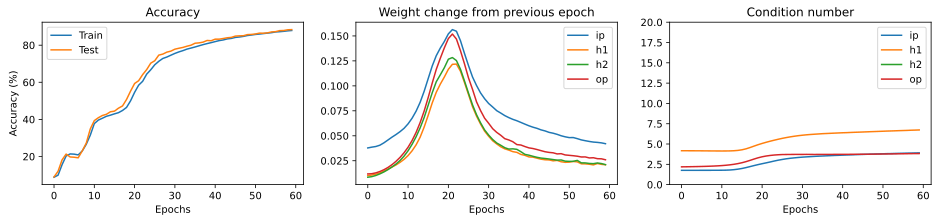

In [129]:
# get a list of layer names
layername = []
for (i,p) in enumerate(net.named_parameters()):
    if 'weight' in p[0]:
        layername.append(p[0][:-7])


# set up the plot
fig,ax = plt.subplots(1,3,figsize=(16,3))

# accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train','Test'])

# weight changes
ax[1].plot(weight_change)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weight_cond)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layername)
ax[2].set_ylim([0,20])

plt.show()

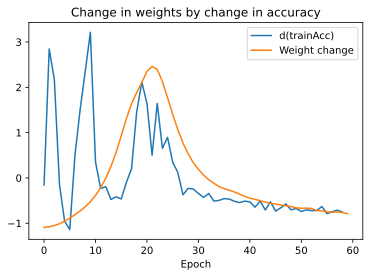

In [130]:
# final inspection: check the derivative of accuracy against the weight change
from scipy.stats import zscore # normalize for scaling offsets

plt.plot(zscore(np.diff(trainAcc)),label='d(trainAcc)')
plt.plot(zscore(np.mean(weight_change,axis=1)),label='Weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epoch')
plt.show()